# Exercise 2: Sub-cellular targeting of cell types in the mouse visual cortex

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">
At the end of Workshop 1, we saw how to get labels on whether synapses were onto spines,
dendritic shafts, or somas. We also plotted this data as adjacency matrices, and made some
qualitative observations about the connectivity of different cell types in the context of 
those connection types.

Here, we'll go through a few steps to turn that into quantifications, specifically, what
fraction of connections between cell types use spines, dendritic shafts, or somas.

</div>


In [1]:
import sys
from os.path import join as pjoin
import platform
import os

# Add the directory for the data and utilities
mat_version = 1196

platstring = platform.platform()
system = platform.system()

HOME = os.path.expanduser("~")

# NOTE: adjust for your system
# data_dir = f"{HOME}/SWDB_2025_Connectomics/data/"
utils_dir = f"{HOME}/code/swdb/SWDB_2025_Connectomics/code/utils"
data_dir = f"{HOME}/code/swdb/SWDB_2025_Connectomics/data/v1dd_{mat_version}"

print(f"Using data directory: {data_dir}")
print(f"Using utils directory: {utils_dir}")
sys.path.append(utils_dir)


Using data directory: /Users/ben.pedigo/code/swdb/SWDB_2025_Connectomics/data/v1dd_1196
Using utils directory: /Users/ben.pedigo/code/swdb/SWDB_2025_Connectomics/code/utils


In [2]:
# Import packages
from caveclient import CAVEclient

import pandas as pd
import numpy as np
import seaborn as sns

In [3]:
# my_token = "PASTE_YOUR_TOKEN
client = CAVEclient(
    datastack_name="v1dd_public",
    server_address="https://global.em.brain.allentech.org",
)

In [4]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(
    pjoin(data_dir, f"proofread_dendrite_list_{mat_version}.npy")
)
axon_proof_root_ids = np.load(pjoin(data_dir, f"proofread_axon_list_{mat_version}.npy"))

proof_root_ids = np.intersect1d(dendrite_proof_root_ids, axon_proof_root_ids)

proof_root_ids

array([864691132534275418, 864691132534315610, 864691132535664474, ...,
       864691133313558608, 864691133313636944, 864691133313665616],
      shape=(1148,))

In [5]:
syn_df = pd.read_feather(
    f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather"
)

In [6]:
from utils import filter_synapse_table

proof_syn_df = filter_synapse_table(syn_df, proof_root_ids, proof_root_ids)

# we're going to copy proof_syn_df to avoid modifying the original DataFrame -
# pandas will often yell at you if you try to modify a DataFrame that is a view of
# another DataFrame
proof_syn_df = proof_syn_df.copy()

proof_syn_df.set_index("id", inplace=True)


In [7]:
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")
cell_df.set_index("pt_root_id", inplace=True)
cell_df = cell_df.loc[proof_root_ids]
cell_df.head()

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,volume,cell_type_coarse,cell_type
pt_root_id,,,,,,,,,,
864691132534275418,295434,739373,633371,323640,-149843.151941,313619.432165,40652.766510,224.683217,E,L4-IT
864691132534315610,294489,823103,635932,272970,-64431.224685,301977.525829,-9080.417561,236.639903,E,L4-IT
864691132535664474,398771,972173,1006782,429480,-56727.602065,731348.504426,-1565.522767,300.366081,E,L6-CT
864691132536286810,308151,860041,818137,270495,-68294.259179,481953.279927,-64048.160336,278.909677,I,DTC
864691132536904794,366084,940822,738674,146565,41834.402292,367661.880467,-158078.097546,273.808765,I,DTC


In [8]:
target_structure = pd.read_feather(
    pjoin(data_dir, f"syn_label_df_all_to_proofread_to_all_{mat_version}.feather")
)["tag"]
target_structure

# Combine the target information to the proofread synapses table
proof_syn_df["target_structure"] = target_structure
proof_syn_df["target_structure"] = proof_syn_df["target_structure"].fillna("unknown")
print(proof_syn_df["target_structure"].value_counts())

target_structure
shaft      134631
spine       45679
soma        13248
unknown      1746
Name: count, dtype: int64


These are the main columns we'll focus on:


In [9]:
proof_syn_df[["pre_pt_root_id", "post_pt_root_id", "target_structure"]].head()

,pre_pt_root_id,post_pt_root_id,target_structure
id,,,
461895313,864691132557909513,864691132931817448,shaft
301049004,864691132578625044,864691132931817448,shaft
436596114,864691132557909513,864691132931817448,shaft
363374679,864691132578625044,864691132786109590,shaft
491726200,864691132562471396,864691132773784759,shaft


We have a table of synapses, but we first want to know what cell types are involved for each.
Although it is a little redundant, it is often useful to simply include the pre- and post-synaptic
cell types in the synapse table. There are many ways to accomplish this in Pandas - a
hint for one option is to use a column's [`.map()`](https://pandas.pydata.org/docs/reference/api/pandas.Series.map.html#pandas.Series.map) method.

Use `.map()` or another method of your choosing to make two new columns in the synapse table:
`proof_syn_df['pre_cell_type']` and `proof_syn_df['post_cell_type']`. The former should
contain the cell type of the pre-synaptic cell for that row's synapse, and the latter
should contain the cell type of the corresponding post-synaptic cell type.


In [10]:
# TODO remove
proof_syn_df["pre_cell_type"] = proof_syn_df["pre_pt_root_id"].map(cell_df["cell_type"])
proof_syn_df["post_cell_type"] = proof_syn_df["post_pt_root_id"].map(
    cell_df["cell_type"]
)

With this information in hand, let's start with just counting the number of synapses
between each pair of cell types and in each target structure category.

In Pandas, [`.groupby()`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html)
is often key to aggregating data. Groupby takes a column name or list of column names, and
then allows you to apply an aggregation function to subsets of the data that share the same values
of those columns. For example, another way to count the total number of synapses in our
table in each target structure category is to do:


In [11]:
proof_syn_df.groupby(
    "target_structure",
    as_index=False,  # this makes the grouping variable(s) into columns instead of the index
).size()  # .size() is a pandas method which counts the number of rows in each group

,target_structure,size
0,shaft,134631
1,soma,13248
2,spine,45679
3,unknown,1746


Just to show the flexibility of `groupby`: this code will group by the `pre_pt_root_id` which indexes the pre-synaptic cell,
select the `ctr_pt_position_y` column which represents the depth of each synapse in nanometers, 
and then compute the mean depth of those synapses from each cell.

In [12]:
(
    proof_syn_df.groupby("pre_pt_root_id", as_index=False)[
        "ctr_pt_position_y"  # this is selecting a column "ctr_pt_position_y" by name
    ].mean()  # this is a pandas method which computes the mean of the selected column per group
)

,pre_pt_root_id,ctr_pt_position_y
0,864691132534275418,694276.248387
1,864691132534315610,654580.013415
2,864691132535664474,909937.600000
3,864691132536286810,763868.042560
4,864691132536904794,619347.957317
...,...,...
1142,864691133311980112,709252.160294
1143,864691133312850768,662119.624490
1144,864691133313558608,834249.919512
1145,864691133313636944,959922.409756


More extensive tutorials on `groupby` can be found in the [Pandas User Guide](https://pandas.pydata.org/docs/user_guide/groupby.html).

Your turn! Returning to our problem of synapse categories and cell types, let's make a new DataFrame that counts the number of synapses between each pair of
cell types in each target structure category. 

For instance, one row might represent the information "there are 38 synapses from L2-IT cells to L3-IT cell shafts". 

The DataFrame should have four columns:
- `pre_cell_type`
- `post_cell_type`
- `target_structure`
- `size` (the number of synapses between the pre- and post-synaptic cell types in that target structure)


In [13]:
# TODO remove
group_structure_counts = proof_syn_df.groupby(
    ["pre_cell_type", "post_cell_type", "target_structure"],
    as_index=False,
).size()
group_structure_counts

,pre_cell_type,post_cell_type,target_structure,size
0,DTC,DTC,shaft,3011
1,DTC,DTC,soma,87
2,DTC,DTC,spine,449
3,DTC,DTC,unknown,2
4,DTC,ITC,shaft,4576
...,...,...,...,...
393,STC,PTC,spine,22
394,STC,STC,shaft,345
395,STC,STC,soma,28
396,STC,STC,spine,96


Now, because we are interested in the _proportion_ of synapses in each cell type pair, we
also need to know the total number of synapses between each pair of cell types, regardless
of target structure. Create another dataframe called `group_total_counts`. It should have
columns for `pre_cell_type`, `post_cell_type`, and `total_size` (the total number of synapses
between the pre- and post-synaptic cell types, regardless of target structure). 

Hint: you might find it useful to use `.rename(columns={"old_name": "new_name"})` to 
rename the `size` column to `total_size`.


In [14]:
# TODO remove
group_total_counts = (
    group_structure_counts.groupby(["pre_cell_type", "post_cell_type"], as_index=False)[
        "size"
    ]
    .sum()
    .rename(columns={"size": "total_size"})
)

# OR

group_total_counts = (
    proof_syn_df.groupby(["pre_cell_type", "post_cell_type"], as_index=False)
    .size()
    .rename(columns={"size": "total_size"})
)
group_total_counts

,pre_cell_type,post_cell_type,total_size
0,DTC,DTC,3549
1,DTC,ITC,5410
2,DTC,L2-IT,6372
3,DTC,L3-IT,18131
4,DTC,L4-IT,4932
...,...,...,...
138,STC,L5-NP,26
139,STC,L6-CT,49
140,STC,L6-IT,125
141,STC,PTC,699


Now, let's think about how to join these tables together. As usual, there are many ways
to do this in Pandas, but one option is to use the [`.merge()`](https://pandas.pydata.org/docs/reference/api/pandas.merge.html) method. This method takes
two DataFrames and joins them together based on one or more columns that they share.
Think about what columns we want to join on, and use `.merge()` to create a new
DataFrame called `group_counts` that contains the following columns:
- `pre_cell_type`
- `post_cell_type`
- `target_structure`
- `size` (the number of synapses between the pre- and post-synaptic cell types in that target structure)
- `total_size` (the total number of synapses between the pre- and post-synaptic cell types, regardless of target structure)


In [15]:
# TODO remove
group_counts = pd.merge(
    group_structure_counts,
    group_total_counts,
    on=["pre_cell_type", "post_cell_type"],
)
group_counts

,pre_cell_type,post_cell_type,target_structure,size,total_size
0,DTC,DTC,shaft,3011,3549
1,DTC,DTC,soma,87,3549
2,DTC,DTC,spine,449,3549
3,DTC,DTC,unknown,2,3549
4,DTC,ITC,shaft,4576,5410
...,...,...,...,...,...
393,STC,PTC,spine,22,699
394,STC,STC,shaft,345,472
395,STC,STC,soma,28,472
396,STC,STC,spine,96,472


Now that we've gone to all that trouble to align our data in this single table, it should
be easy to calculate the _proportion_ of synapses in each target structure category for each
pair of cell types. Add a new column to `group_counts` called `proportion`, which is the
`size` divided by `total_size`.

In [16]:
# TODO remove
group_counts["proportion"] = group_counts["size"] / group_counts["total_size"]
group_counts

,pre_cell_type,post_cell_type,target_structure,size,total_size,proportion
0,DTC,DTC,shaft,3011,3549,0.848408
1,DTC,DTC,soma,87,3549,0.024514
2,DTC,DTC,spine,449,3549,0.126515
3,DTC,DTC,unknown,2,3549,0.000564
4,DTC,ITC,shaft,4576,5410,0.845841
...,...,...,...,...,...,...
393,STC,PTC,spine,22,699,0.031474
394,STC,STC,shaft,345,472,0.730932
395,STC,STC,soma,28,472,0.059322
396,STC,STC,spine,96,472,0.203390


We have what we said we wanted to compute - but let's transform it a bit to make it 
easier to plot. The code below will first query to select the proportions of synapses onto spines, 
and then [pivot](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.pivot.html) the DataFrame to make it square matrix which we'll plot.

In [20]:
square_spine_counts = group_counts.query("target_structure == 'spine'").pivot(
    index="pre_cell_type", columns="post_cell_type", values="proportion"
)

# to make our plot look nicer, this code just reorders the categories to be first by
# excitatory/inhibitory, then by layer, and finally by cell type
categories = [
    "L2-IT",
    "L3-IT",
    "L4-IT",
    "L5-IT",
    "L5-ET",
    "L5-NP",
    "L6-IT",
    "L6-CT",
    "DTC",
    "ITC",
    "PTC",
    "STC",
]
square_spine_counts = square_spine_counts.reindex(index=categories, columns=categories)
square_spine_counts

post_cell_type,L2-IT,L3-IT,L4-IT,L5-IT,L5-ET,L5-NP,L6-IT,L6-CT,DTC,ITC,PTC,STC
pre_cell_type,,,,,,,,,,,,
L2-IT,0.915114,0.929603,0.954545,0.903704,0.871145,0.500000,0.736842,0.900000,0.291408,0.151235,0.070913,0.223938
L3-IT,0.912000,0.923630,0.899371,0.918033,0.889861,0.428571,0.907407,0.892857,0.221413,0.135283,0.054801,0.234375
L4-IT,0.924528,0.944578,0.896104,0.900826,0.920110,NaN,1.000000,0.852941,0.193565,0.054545,0.031771,0.210000
L5-IT,0.960526,0.962428,0.900000,0.868421,0.882045,0.230769,0.954545,0.852941,0.219959,0.116822,0.050510,0.230159
L5-ET,0.793103,0.865854,0.625000,0.826087,0.649351,0.729730,0.629630,0.875000,0.375701,0.152174,0.096711,0.235294
L5-NP,0.800000,0.714286,1.000000,0.520000,0.276151,NaN,0.956522,0.950000,0.157068,0.057692,0.063889,0.176471
L6-IT,0.833333,1.000000,1.000000,0.800000,0.692308,0.500000,0.887324,0.956522,0.130781,0.285714,0.050598,0.173913
L6-CT,NaN,1.000000,NaN,0.666667,0.234375,0.071429,0.900000,0.956522,0.105802,NaN,0.025788,0.200000
DTC,0.249686,0.235232,0.234996,0.281485,0.244227,0.160377,0.384892,0.239819,0.126515,0.091312,0.036316,0.101086


<Axes: xlabel='post_cell_type', ylabel='pre_cell_type'>

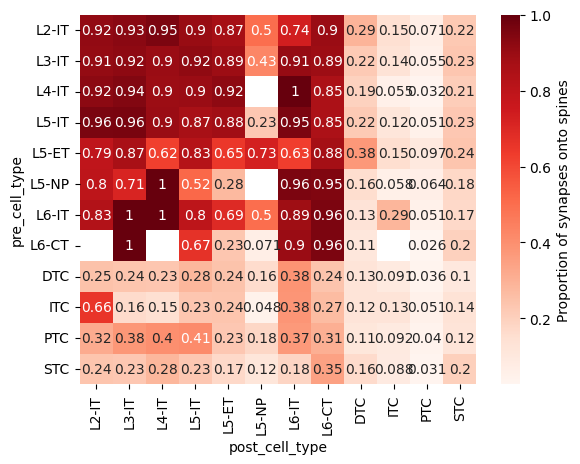

In [18]:
sns.heatmap(
    square_spine_counts,
    annot=True,
    cmap="Reds",
    cbar_kws={"label": "Proportion of synapses onto spines"},
)

Now, create similar plots for the other target structures. 

What general trends do you
notice about what connection types are using what "channels" of synaptic targeting?

What sources of bias might affect the reliability of these proportions?

Bonus exercise: how much more common are synapses onto spines for excitatory cells compared to inhibitory cells? You should be able to compute the proportion of synapses onto spines for each individual cell using the same tools we developed above. Note that you will want a different filter on the synapse table than we used here (why?). 

How does this one feature perform as a classifier for excitatory vs. inhibitory cells? What would be the drawbacks of using this feature as a classifier in practice? 

<Axes: xlabel='p_spine', ylabel='Count'>

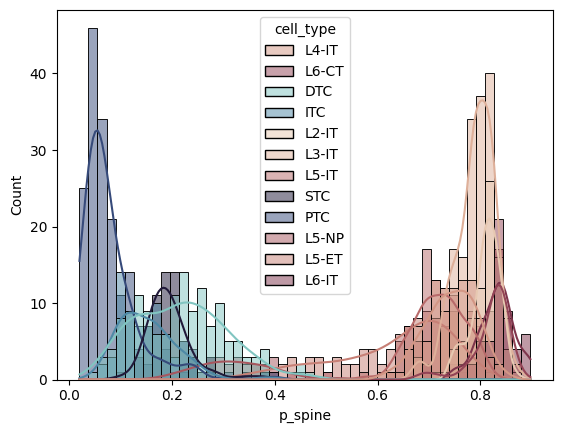

In [ ]:
proof_syn_df = (
    filter_synapse_table(syn_df, post_root_ids=proof_root_ids).set_index("id").copy()
)
proof_syn_df["pre_cell_type"] = proof_syn_df["pre_pt_root_id"].map(cell_df["cell_type"])
proof_syn_df["post_cell_type"] = proof_syn_df["post_pt_root_id"].map(
    cell_df["cell_type"]
)
proof_syn_df["target_structure"] = target_structure
cell_structure_counts = proof_syn_df.groupby(
    ["post_pt_root_id", "target_structure"], as_index=False
).size()
cell_total_counts = (
    proof_syn_df.groupby("post_pt_root_id", as_index=False)
    .size()
    .rename(columns={"size": "total_size"})
)
cell_structure_counts = pd.merge(
    cell_structure_counts,
    cell_total_counts,
    on="post_pt_root_id",
)
cell_structure_counts["proportion"] = (
    cell_structure_counts["size"] / cell_structure_counts["total_size"]
)

cell_proportions = cell_structure_counts.pivot(
    index="post_pt_root_id", columns="target_structure", values="proportion"
).rename(columns=lambda x: f"p_{x}")
cell_proportions["cell_type"] = cell_proportions.index.map(cell_df["cell_type"])

from utils import cell_type_palette

sns.histplot(
    cell_proportions,
    x="p_spine",
    kde=True,
    bins=50,
    hue="cell_type",
    palette=cell_type_palette,
)